In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from keras.models import Model
from keras.layers import Layer
from keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from keras.optimizers import Adam
from keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from keras.regularizers  import L2, L1
# from tf.train import BytesList, FloatList, Int64List 
# from tf.train import Example, Features, Feature

BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Example = tf.train.Example
Features = tf.train.Features
Feature = tf.train.Feature



2024-06-03 21:22:55.339133: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 21:22:55.531257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 21:22:56.070411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data Management

In [2]:
# Set the seed for random operations.
SEED = 42

# Set the seed for random operations.
random.seed(SEED)

# Set the seed for tensorflow operations.
tf.random.set_seed(SEED)

In [3]:
train_directory = "./datasets/Emotions_Dataset/train"
val_directory = "./datasets/Emotions_Dataset/test"
CLASS_NAMES = ['angry', 'happy', 'sad']



CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-2,
    "N_EPOCHS": 100,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

IM_SIZE = CONFIGURATION["IM_SIZE"]



## Data Downloading

In [4]:
# %%bash

# kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

## Dataset Loading

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
    # validation_split=0.2,
    # subset="training"
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
    # validation_split=0.2,
    # subset="validation"
)


Found 6799 files belonging to 3 classes.


2024-06-03 21:22:58.813019: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 21:22:58.885924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 21:22:58.890267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 2278 files belonging to 3 classes.


## Dataset Visualization

2024-06-03 21:22:59.931899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


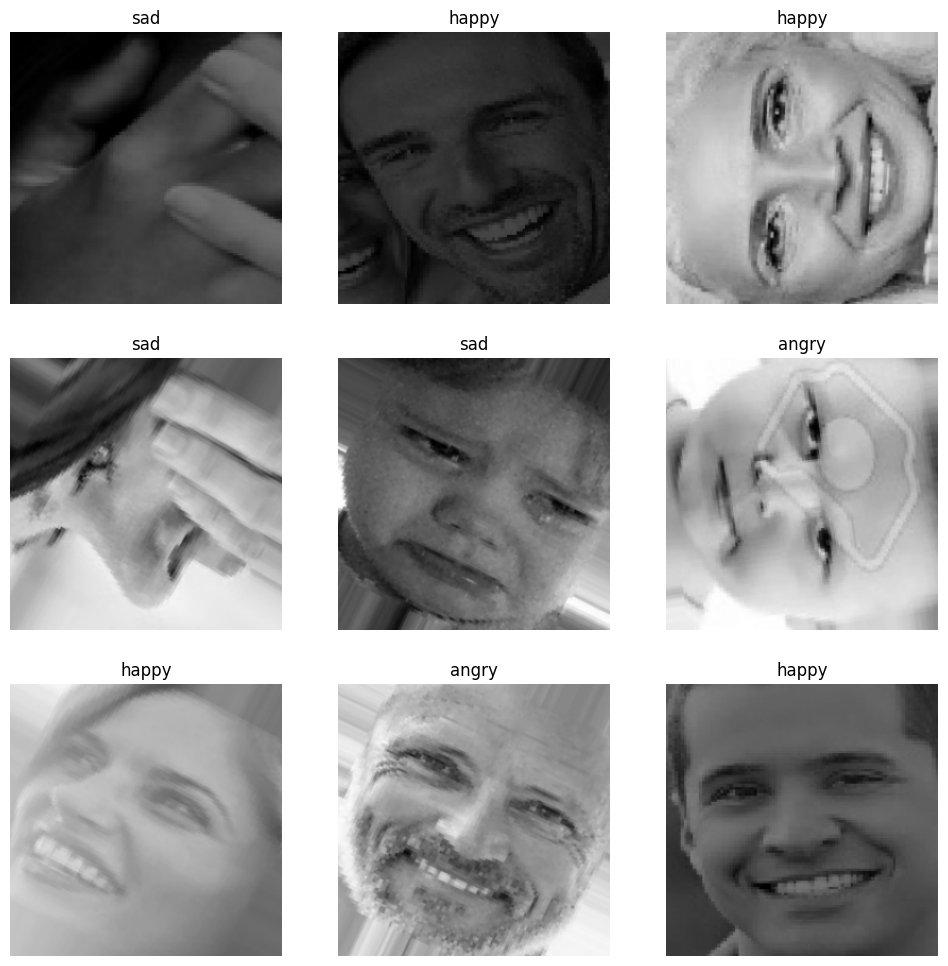

In [6]:
plt.figure(figsize=(12, 12))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[np.argmax(labels[i])])
        plt.axis("off")

## Data Augmentation

In [7]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025, 0.025)),
    RandomFlip(mode="horizontal"),
    RandomContrast(factor=(0.25, 0.251)),
])

In [8]:
def augment_layer(image, label):
    return augment_layers(image, training = True), label

### CutMix Augmentation

In [9]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [10]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

## Data Preparation

In [11]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [12]:
# 


# training_dataset = (
#     mixed_dataset
#     .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
#     # .prefetch(tf.data.AUTOTUNE)
# )


training_dataset = train_dataset.map(augment_layer, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [13]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1./255)
])

In [14]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

### TFRecords

In [15]:
# training_dataset = training_dataset.unbatch()
# validation_dataset = validation_dataset.unbatch()

In [16]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [17]:
NUM_SHARDS = 10

PATH ='tfrecords/shard_{:02d}.tfrecord'

In [18]:
def encode_images(image, label):
    image = tf.image.convert_image_dtype(image, tf.uint8)
    image = tf.io.encode_jpeg(image)
    # label must be int
    label = tf.argmax(label)
    return image, label

In [19]:
# encoded_dataset = training_dataset.map(encode_images)

In [20]:
# for shard_number in range(NUM_SHARDS):
#     sharded_dataset = encoded_dataset.shard(NUM_SHARDS, shard_number).as_numpy_iterator()


#     with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
#         for encoded_image, encoded_label in sharded_dataset:
#             example = create_example(encoded_image, encoded_label)
#             file_writer.write(example)

In [21]:
# recons_dataset = tf.data.TFRecordDataset(filenames=[PATH.format(p) for p in range(NUM_SHARDS)])

In [22]:
def parse_tfrecord_fn(example):
    feature_description = {
        'images': tf.io.FixedLenFeature([], tf.string),
        'labels': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example['images'] = tf.io.decode_jpeg(example['images'], channels=3)

    return example['images'], example['labels']


In [23]:
# parsed_dataset = recons_dataset.map(parse_tfrecord_fn).batch(CONFIGURATION["BATCH_SIZE"]).prefetch(tf.data.AUTOTUNE)

# for image, label in parsed_dataset.take(1):
#     plt.figure(figsize=(12, 12))
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(image[i].numpy().astype("uint8"))
#         plt.title(CLASS_NAMES[label[i]])
#         plt.axis("off")



In [24]:
# print one batch of the dataset
for image, label in training_dataset.take(1):
    print(image)

tf.Tensor(
[[[[ 25.354996   25.354996   25.354996 ]
   [ 25.662888   25.662888   25.662888 ]
   [ 26.211838   26.211838   26.211838 ]
   ...
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]]

  [[ 31.501755   31.501755   31.501755 ]
   [ 29.220596   29.220596   29.220596 ]
   [ 26.035637   26.035637   26.035637 ]
   ...
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]]

  [[ 38.4904     38.4904     38.4904   ]
   [ 35.247463   35.247463   35.247463 ]
   [ 28.201683   28.201683   28.201683 ]
   ...
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]
   [  0.          0.          0.       ]]

  ...

  [[109.834854  109.834854  109.834854 ]
   [109.55412   109.55412   109.55412  ]
   [109.19087   109.19087   109.19087  ]
   ...
   [134.33319   134.33319   134.33319  ]
   [130.52974   130.52974   130.52974  ]
   [1

2024-06-03 21:23:01.242467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Modeling

In [25]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3)),
    
#     Rescaling(1./255),
      resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

/home/kervin/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    62,981,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,118,451 (240.78 MB)

 Trainable params: 63,116,103 (240.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

### Tranfer Learning

#### EfficientNet

In [26]:
backbone = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(IM_SIZE, IM_SIZE, 3),
)

In [27]:
# We're freezing the backbone to avoid updating the weights
backbone.trainable = False

In [28]:
pretrained_model = tf.keras.Sequential([
        Input(shape=(IM_SIZE, IM_SIZE, 3)),
        backbone,
        GlobalAveragePooling2D(),
        Dense(CONFIGURATION["N_DENSE_1"], activation='relu'),
        BatchNormalization(),
        Dense(CONFIGURATION["N_DENSE_2"], activation='relu'),
        Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')
])


pretrained_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 8, 8, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,836,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

#### Fine Tuning EfficientNet

In [29]:
# backbone.trainable = True

In [30]:
# input = Input(shape=(IM_SIZE, IM_SIZE, 3))
# x = backbone(input, training=False)
# x = GlobalAveragePooling2D()(x)
# x = Dense(CONFIGURATION["N_DENSE_1"], activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dense(CONFIGURATION["N_DENSE_2"], activation='relu')(x)
# output = Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')(x)

# finetuned_model = Model(inputs=input, outputs=output)


In [31]:
# finetuned_model.summary()

## Training

In [32]:
# tensorflow version
print(tf.__version__)

2.16.1


In [33]:
# Check if GPU is available
# print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [34]:
loss_function = CategoricalCrossentropy()

In [35]:
metrics = [CategoricalAccuracy(), TopKCategoricalAccuracy(k=2, name="top_2_categorical_accuracy")]
# metrics = [SparseCategoricalAccuracy()]

In [36]:
# lenet_model.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]), loss=loss_function, metrics=metrics)
pretrained_model.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]), 
                         loss=loss_function, 
                         metrics=metrics)

In [37]:
# Early stopping callback
early_stopping = EarlyStopping(monitor="categorical_accuracy", patience=3, restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor="categorical_accuracy", factor=0.1, patience=2, min_lr=1e-20, mode="min")

In [38]:
n_sample_0 = 1525
n_sample_1 = 3019
n_sample_2 = 2255

class_weight = {0: 6799/n_sample_0, 1: 6799/n_sample_1, 2: 6799/n_sample_2}

In [39]:
# history = lenet_model.fit(train_dataset,
#                            validation_data=validation_dataset, 
#                            epochs=CONFIGURATION["N_EPOCHS"], verbose=1
#                            ,callbacks=[early_stopping, reduce_lr]
#                              )


history = pretrained_model.fit(training_dataset,
                            validation_data=validation_dataset, 
                            epochs=CONFIGURATION["N_EPOCHS"], 
                            verbose=1,
                            callbacks=[early_stopping, reduce_lr],
                            class_weight = class_weight
                              )

Epoch 1/100


I0000 00:00:1717474989.573565    6369 service.cc:145] XLA service 0x73a774003050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717474989.573589    6369 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-06-03 21:23:10.376955: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-03 21:23:11.606859: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1717475002.059648    6592 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_24223', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1717475002.068114    6589 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_24223', 40 bytes spill stores, 40 bytes spill loads

I0000 00

  6/213 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - categorical_accuracy: 0.4652 - loss: 10.3982 - top_2_categorical_accuracy: 0.7494 

I0000 00:00:1717475010.740896    6369 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.5892 - loss: 5.1058 - top_2_categorical_accuracy: 0.8571

I0000 00:00:1717475027.094435    8193 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_23807', 8 bytes spill stores, 8 bytes spill loads



213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - categorical_accuracy: 0.5894 - loss: 5.0968 - top_2_categorical_accuracy: 0.8572

I0000 00:00:1717475039.626700   10087 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4025', 24 bytes spill stores, 24 bytes spill loads



213/213 ━━━━━━━━━━━━━━━━━━━━ 59s 146ms/step - categorical_accuracy: 0.5896 - loss: 5.0880 - top_2_categorical_accuracy: 0.8572 - val_categorical_accuracy: 0.7054 - val_loss: 0.6576 - val_top_2_categorical_accuracy: 0.8995 - learning_rate: 0.0100
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - categorical_accuracy: 0.7001 - loss: 2.1305 - top_2_categorical_accuracy: 0.8987 - val_categorical_accuracy: 0.7265 - val_loss: 0.6196 - val_top_2_categorical_accuracy: 0.9061 - learning_rate: 0.0100
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - categorical_accuracy: 0.7232 - loss: 2.0079 - top_2_categorical_accuracy: 0.9087 - val_categorical_accuracy: 0.7414 - val_loss: 0.6080 - val_top_2_categorical_accuracy: 0.9069 - learning_rate: 0.0100
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - categorical_accuracy: 0.7641 - loss: 1.7301 - top_2_categorical_accuracy: 0.9238 - val_categorical_accuracy: 0.7704 - val_loss: 0.5304 - val_top_2_categorical_accuracy: 0.9197 - learning

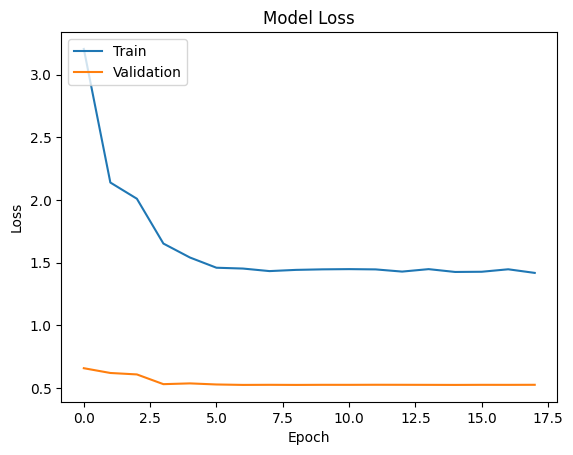

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

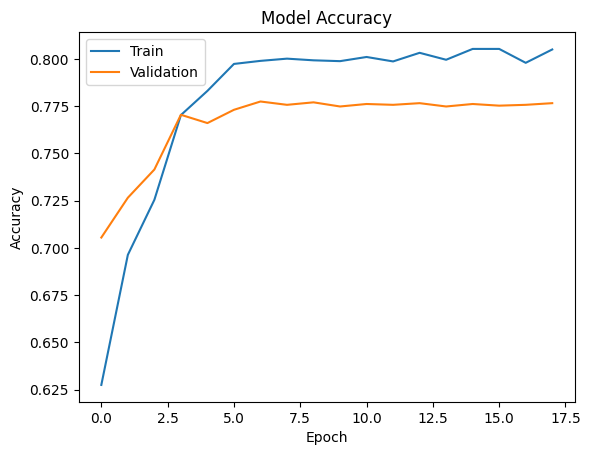

In [41]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluate the model

In [42]:
# lenet_model.evaluate(validation_dataset)
pretrained_model.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.7655 - loss: 0.5370 - top_2_categorical_accuracy: 0.9275


[0.5243187546730042, 0.7761194109916687, 0.9258121252059937]

## Testing

In [43]:
test_image = cv2.imread("./datasets/Emotions_Dataset/test/sad/1670.jpg")

im = tf.constant(test_image, dtype=tf.float32)

im = tf.image.resize(im, (IM_SIZE, IM_SIZE))
im = tf.expand_dims(im, axis=0)
print(CLASS_NAMES[np.argmax(pretrained_model.predict(im))])


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
sad


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-06-03 21:26:02.184612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


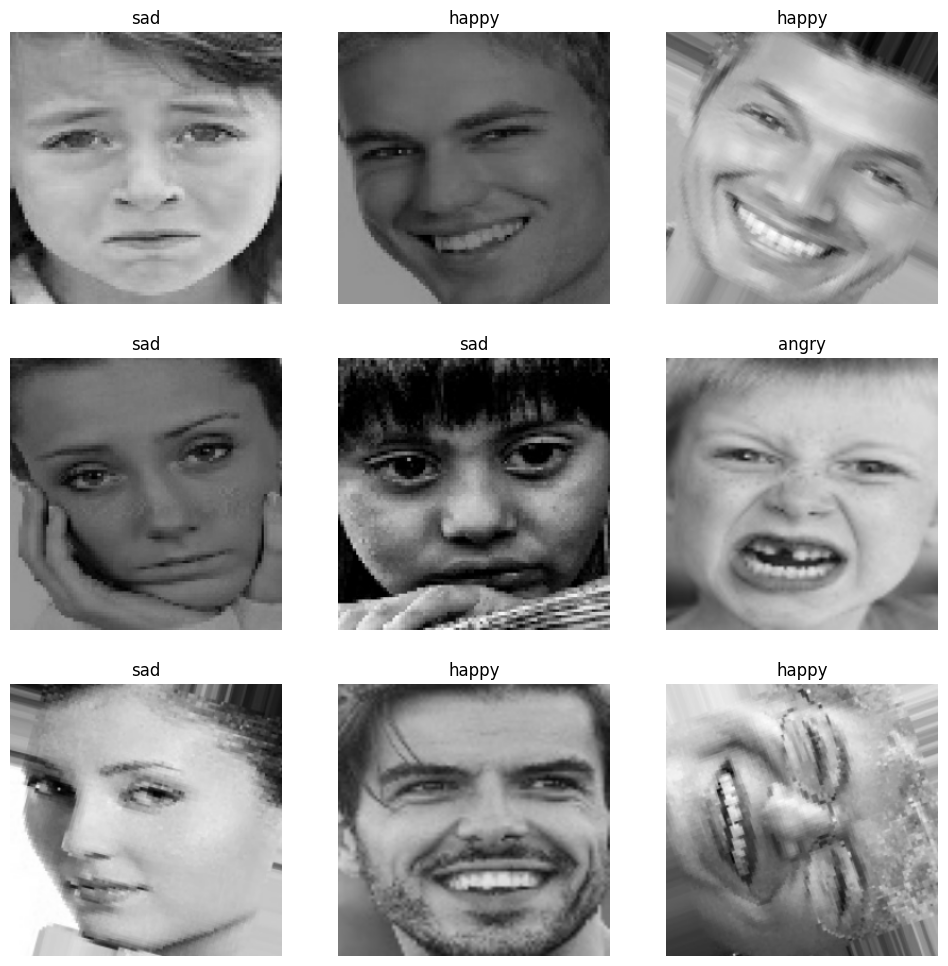

In [44]:
plt.figure(figsize=(12, 12))

for images, labels in val_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[np.argmax(labels[i])])
        plt.axis("off")

        im = tf.expand_dims(images[i], axis=0)
        plt.title(CLASS_NAMES[np.argmax(pretrained_model.predict(im))])

## Confusion Matrix

In [45]:
predicted = []
labels = []

for im, label in val_dataset:
    # predicted.extend(np.argmax(lenet_model.predict(im, verbose=0), axis=1))
    predicted.extend(np.argmax(pretrained_model.predict(im, verbose=0), axis=1))
    labels.extend(np.argmax(label, axis=1))


predicted = np.array(predicted, dtype=np.int32)
labels = np.array(labels, dtype=np.int32)

print(len(labels))
print(len(predicted))


2278
2278


2024-06-03 21:26:10.319843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [46]:
print(predicted)

[1 2 2 ... 0 2 2]


In [47]:
print(labels)

[1 1 1 ... 0 2 2]


In [48]:
# convert predicted and labels to float32
predicted = np.array(predicted, dtype=np.float32)

[[348  49 118]
 [ 59 822 125]
 [101  58 598]]


Text(0.5, 58.7222222222222, 'Predicted')

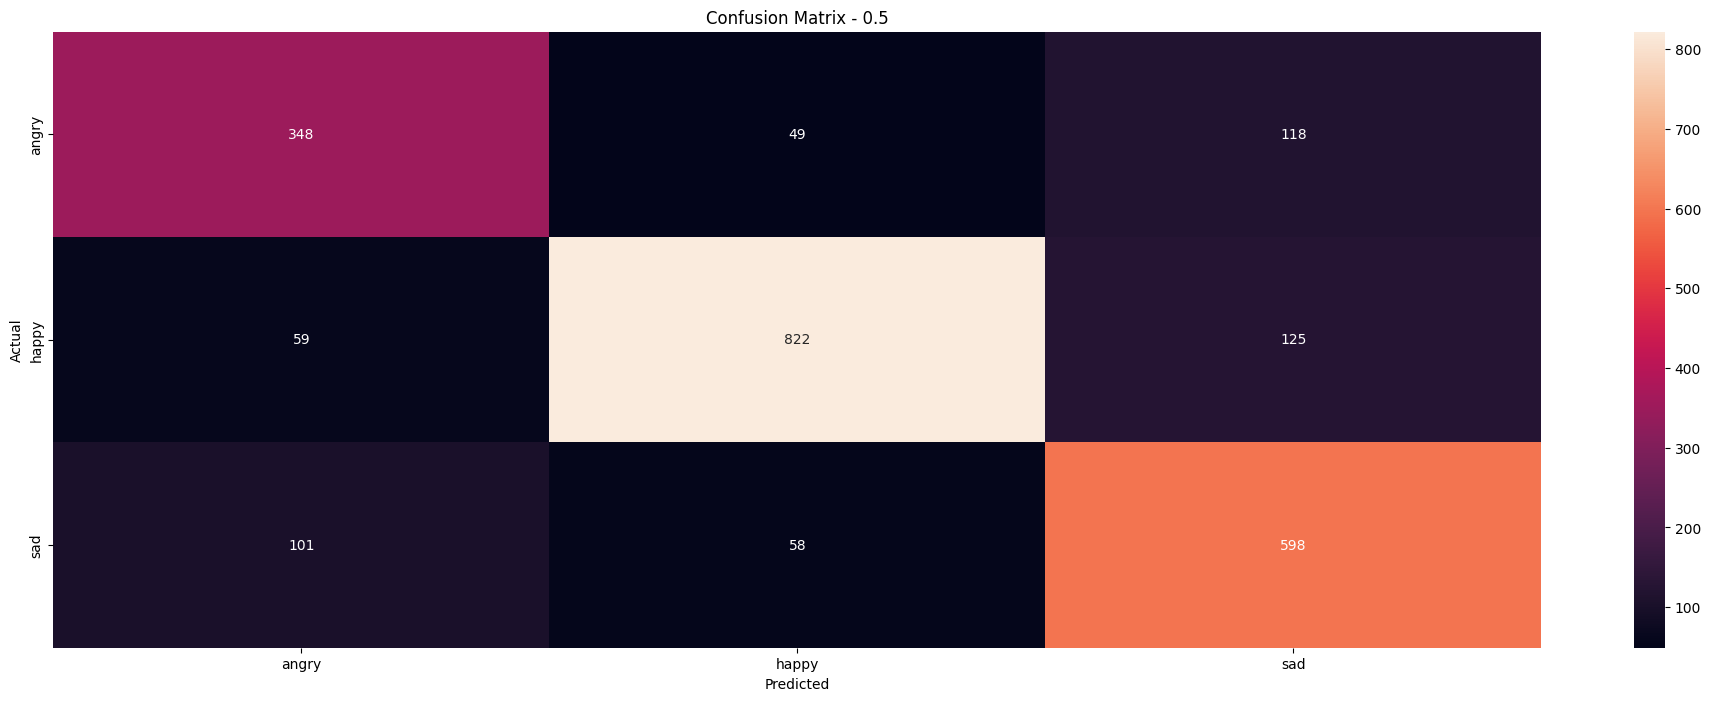

In [49]:
threshold = 0.5

cm = confusion_matrix(labels, predicted)
print(cm)
plt.figure(figsize=(24,8))

sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix - {}".format(threshold))
plt.ylabel("Actual")
plt.xlabel("Predicted")

## Visualization

In [50]:
vgg_backbone = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
)

vgg_backbone.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if "conv" in layer.name]
feature_map_model = Model(inputs=vgg_backbone.input, outputs=feature_maps)

feature_map_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
test_image = cv2.imread("./datasets/Emotions_Dataset/test/sad/1670.jpg")
test_image = cv2.resize(test_image, (IM_SIZE, IM_SIZE))

im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)

f_maps = feature_map_model.predict(im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step


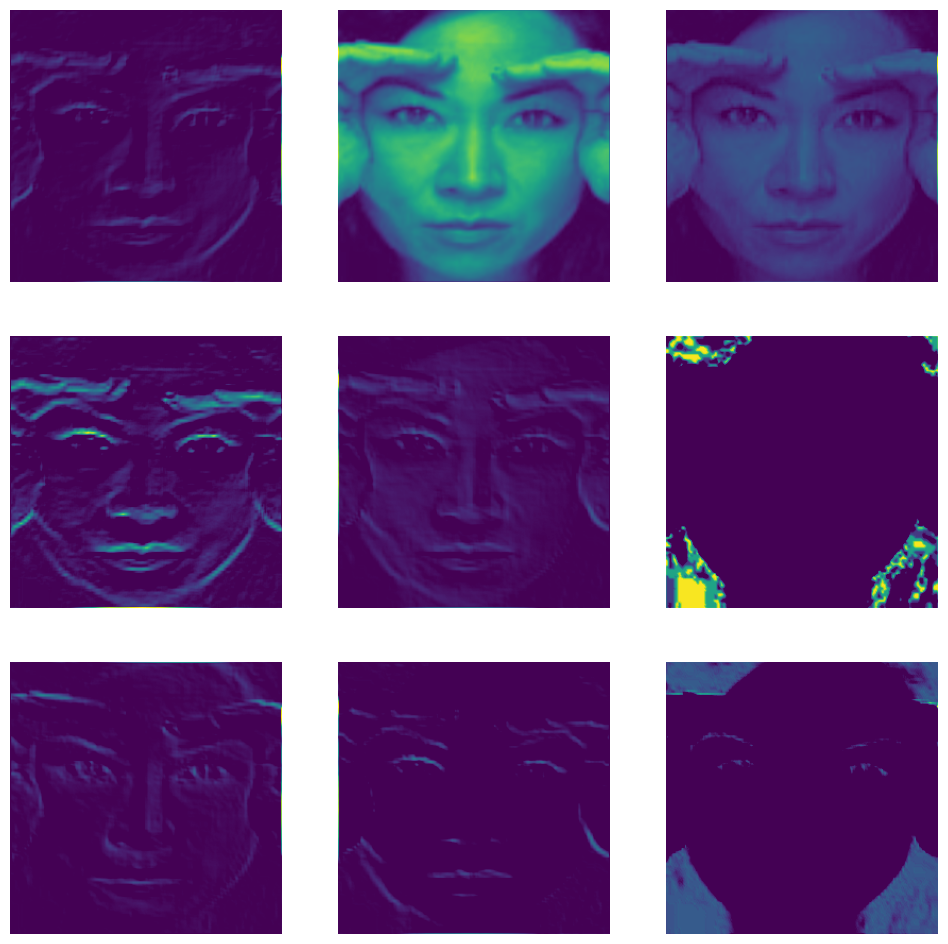

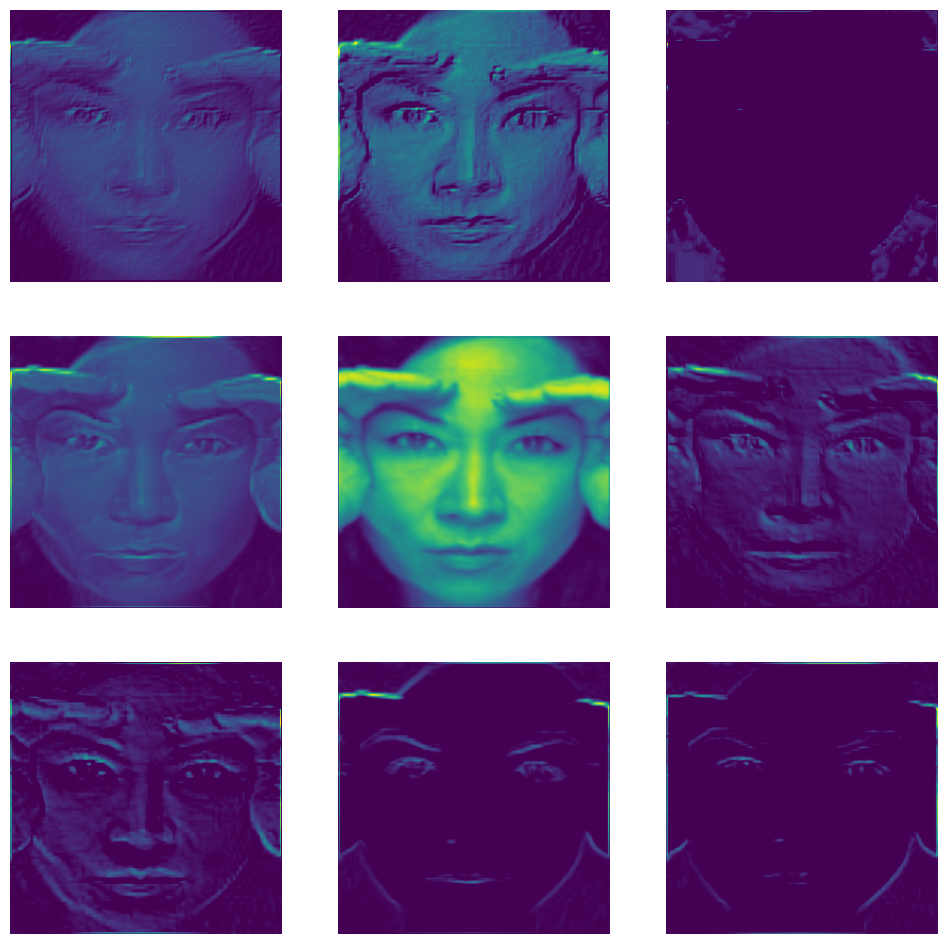

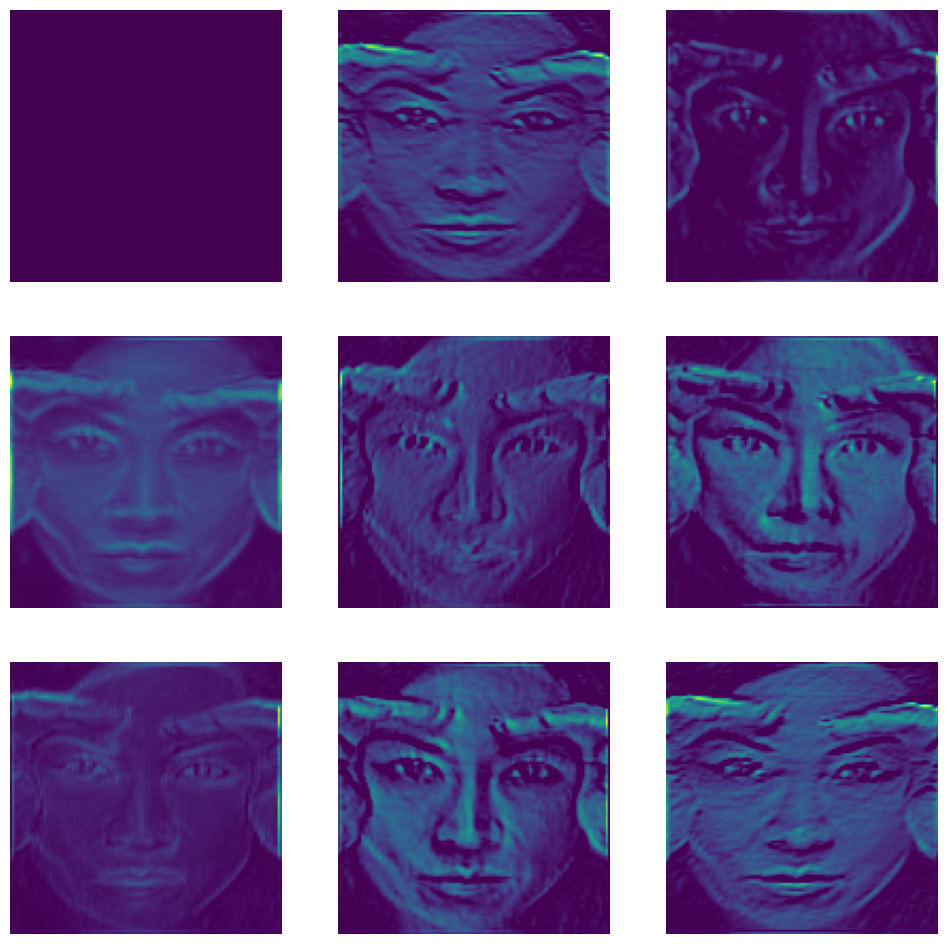

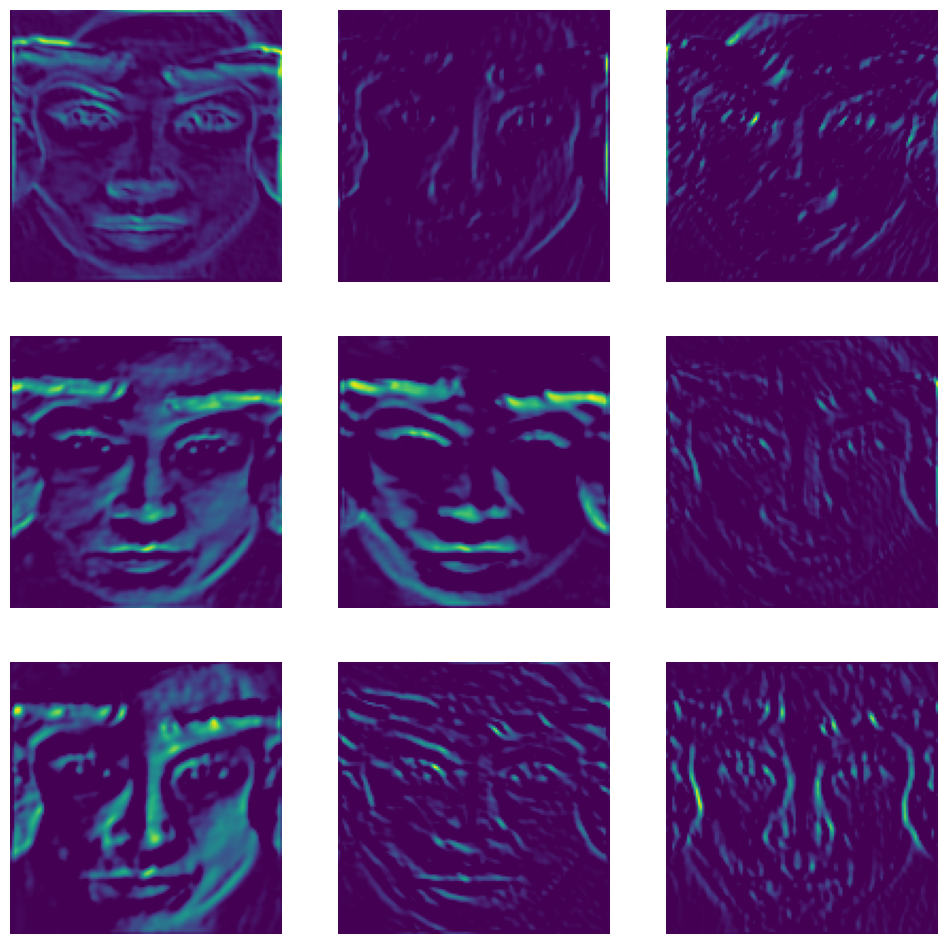

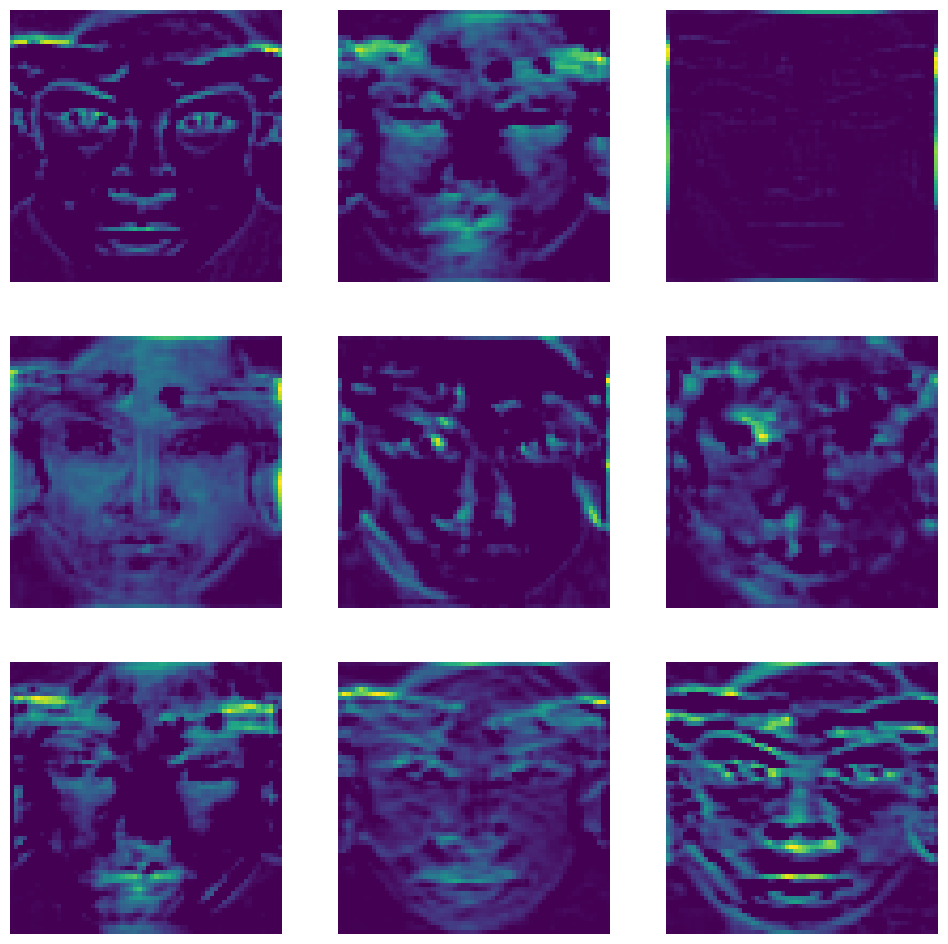

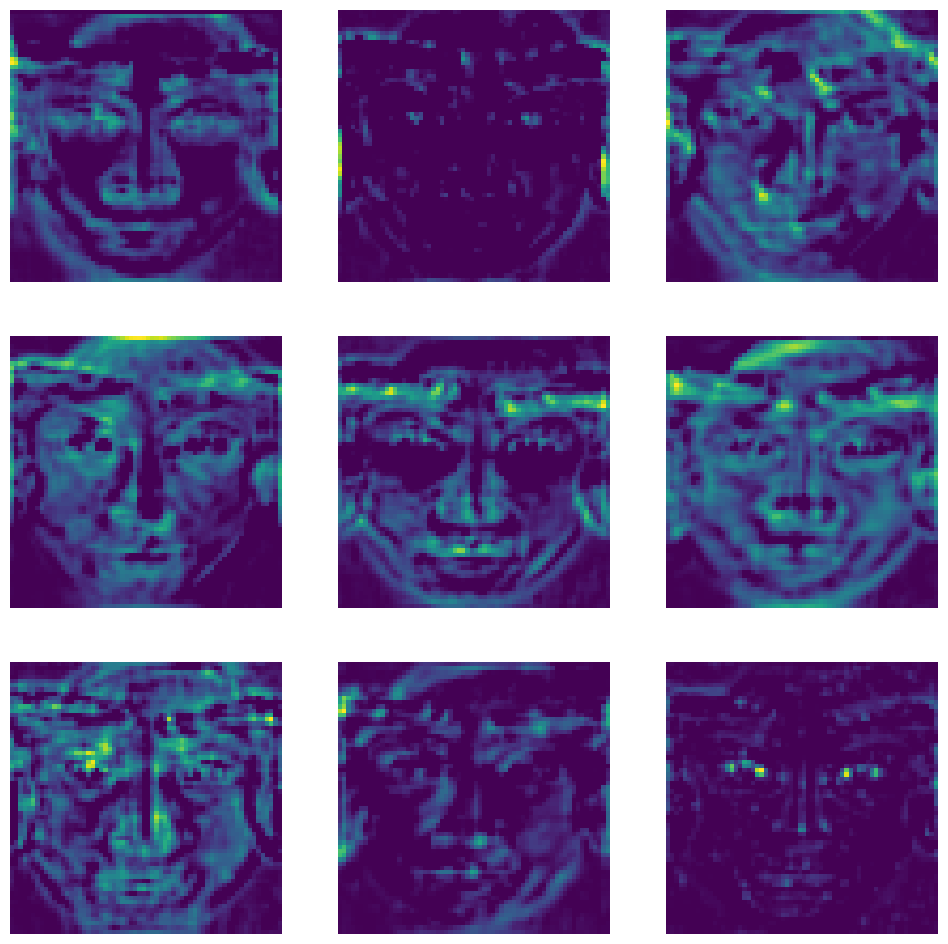

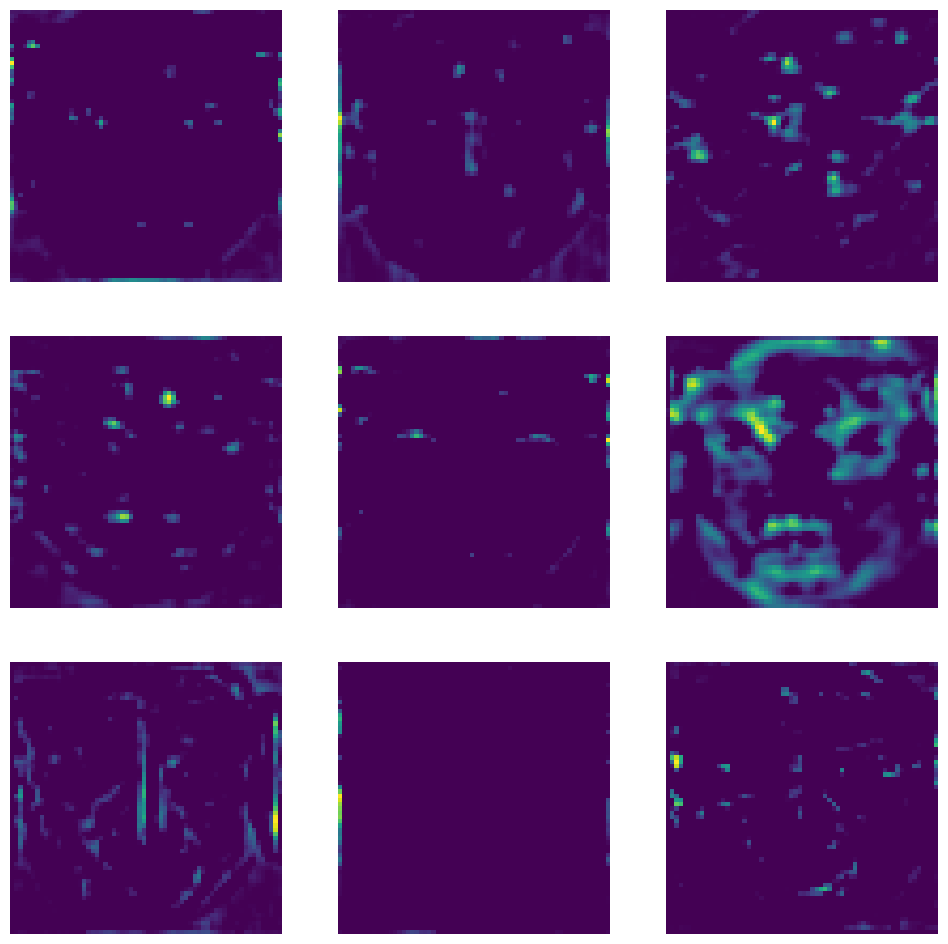

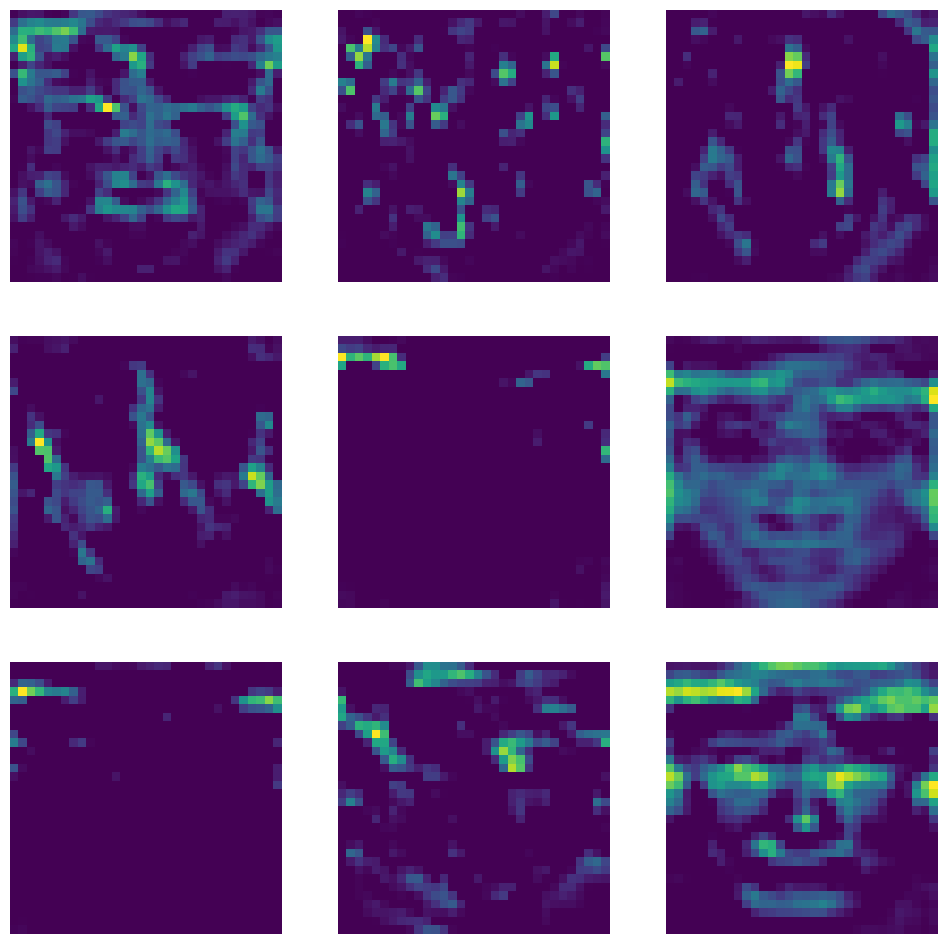

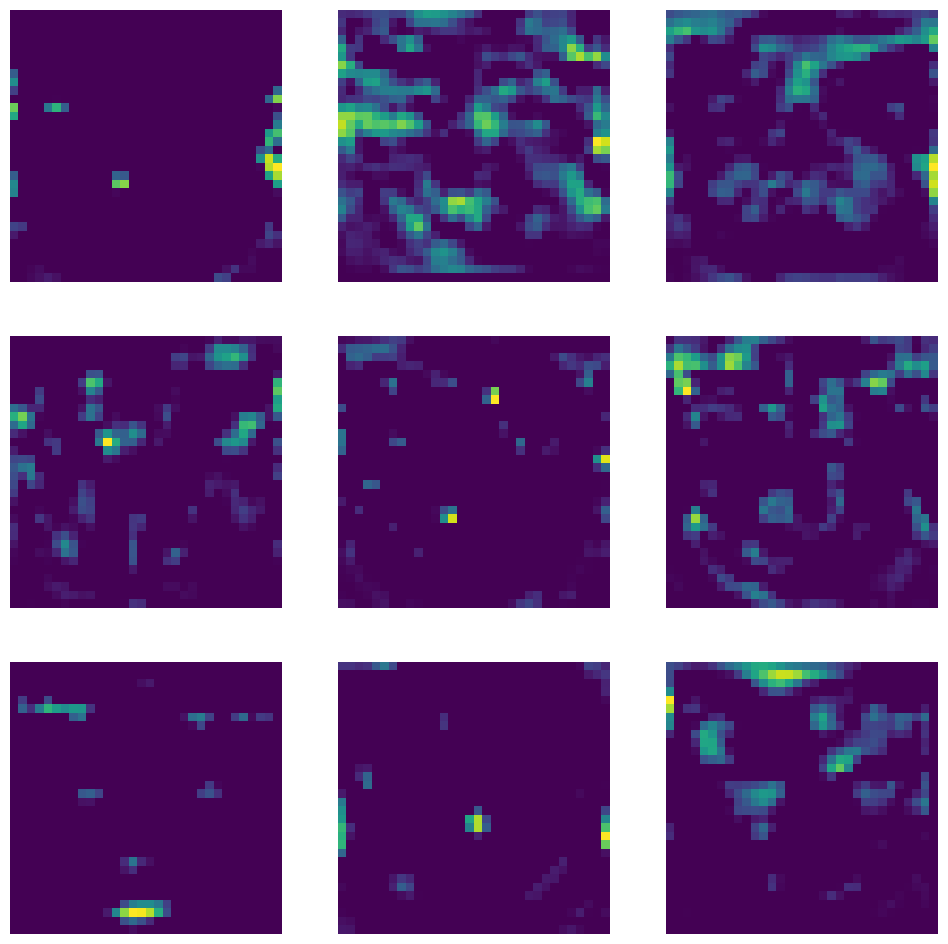

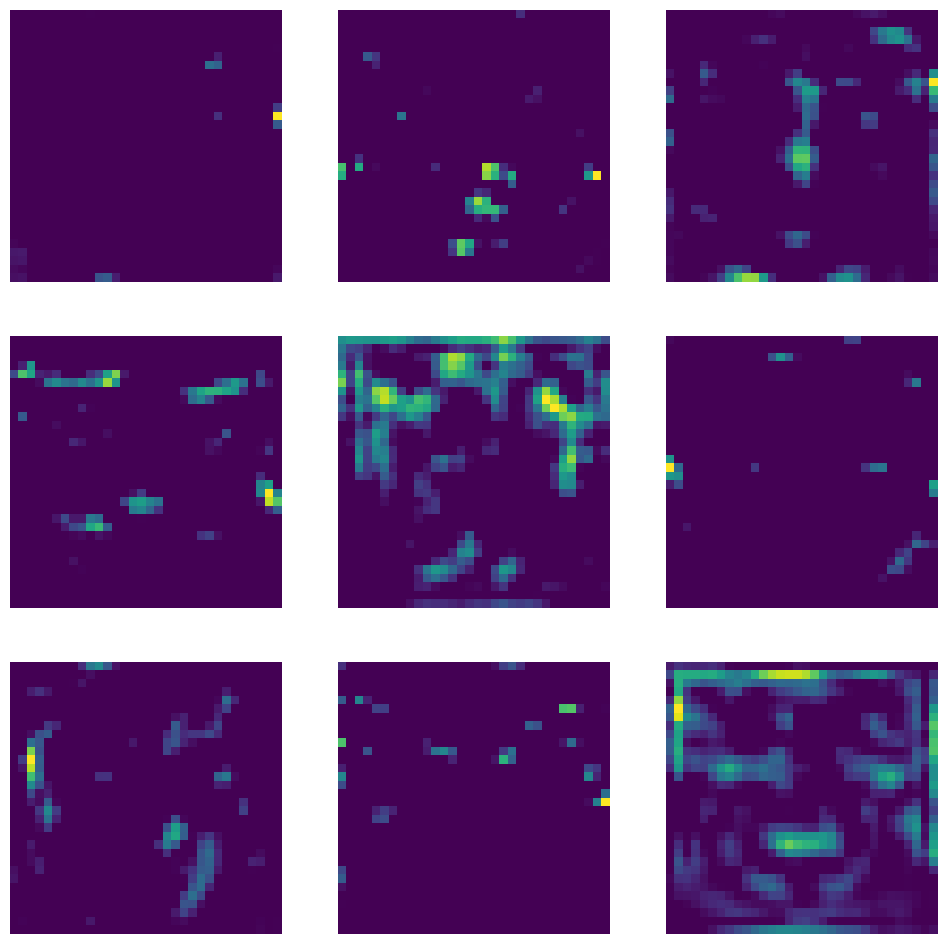

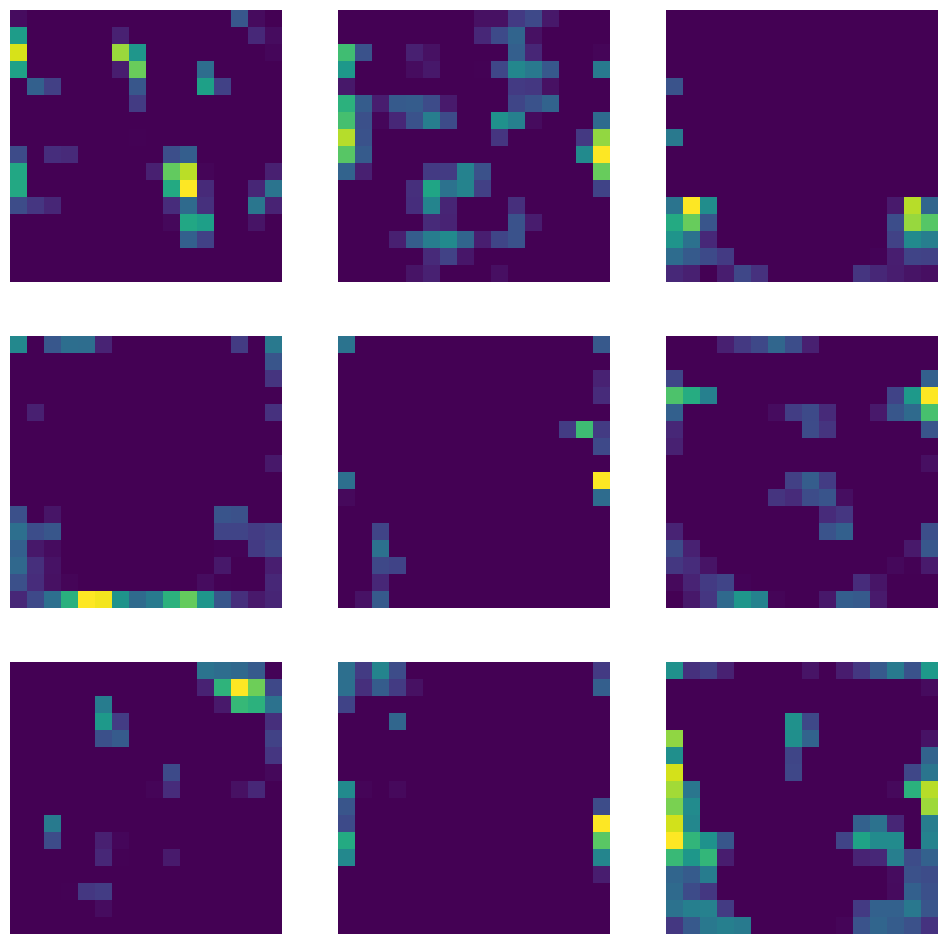

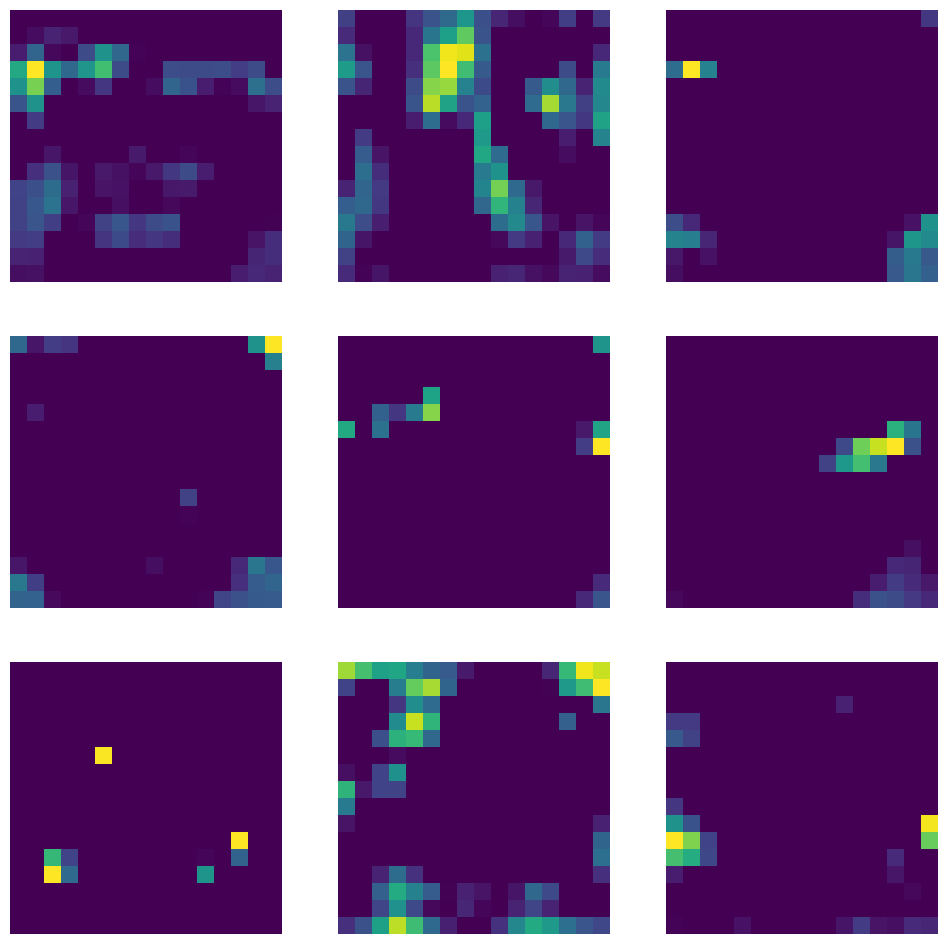

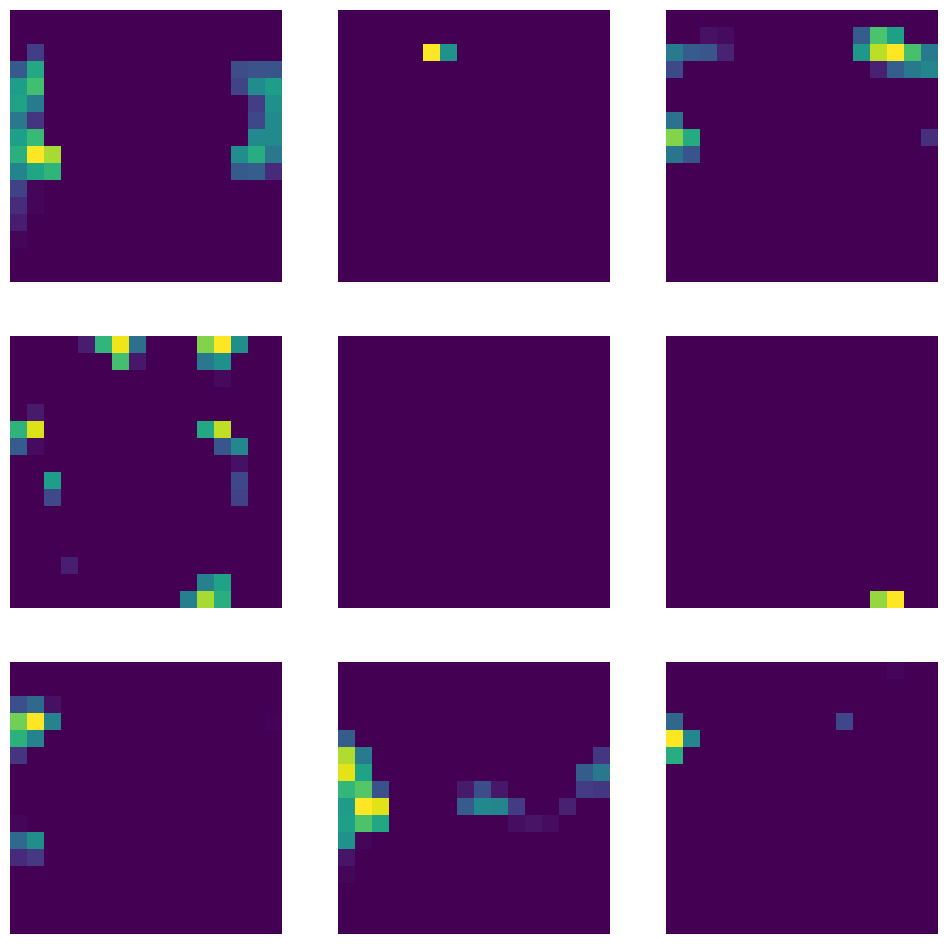

In [53]:
for i in range(len(f_maps)):
    plt.figure(figsize=(12, 12))
    for j in range(9):
        ax = plt.subplot(3, 3, j + 1)
        plt.imshow(f_maps[i][0, :, :, j])
        plt.axis("off")

## GradCam

In [54]:
backbone = tf.keras.applications.EfficientNetB5(
    include_top=False,
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
)

backbone.trainable = False

In [55]:
x =  backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(CONFIGURATION["N_DENSE_1"], activation="relu")(x)
x = Dense(CONFIGURATION["N_DENSE_2"], activation="relu")(x)

output = Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")(x)

pretrained_model = Model(inputs=backbone.input, outputs=output)
pretrained_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 256, 256,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 256, 256,  │          7 │ rescaling_3[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 256, 256,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_4[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │      1,152 │ block1a_se_excit

 Total params: 30,743,290 (117.28 MB)

 Trainable params: 2,229,763 (8.51 MB)

 Non-trainable params: 28,513,527 (108.77 MB)

In [56]:
img_path = "./datasets/Emotions_Dataset/test/sad/1670.jpg"

In [57]:
test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (IM_SIZE, IM_SIZE))
im = tf.constant(test_image, dtype=tf.float32)
img_array = tf.expand_dims(im, axis=0)
print(img_array.shape)

(1, 256, 256, 3)


In [58]:
preds = pretrained_model.predict(img_array)
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[0.3252591, 0.3333651, 0.3413758]], dtype=float32)

In [59]:
last_conv_layer_name = "top_activation"
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(pretrained_model.inputs, last_conv_layer.output)
last_conv_layer_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 256, 256,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 256, 256,  │          7 │ rescaling_3[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 256, 256,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_4[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │      1,152 │ block1a_se_excit

 Total params: 28,513,527 (108.77 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 28,513,527 (108.77 MB)

In [60]:
classifier_layer_names = [
    "global_average_pooling2d_1",
    "dense_6",
    "dense_7",
    "dense_8"
]

In [61]:
classifier_input = Input(shape=(8,8,2048))
x = classifier_input
for layer_name in classifier_layer_names:
    x = pretrained_model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)

In [62]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [63]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [64]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

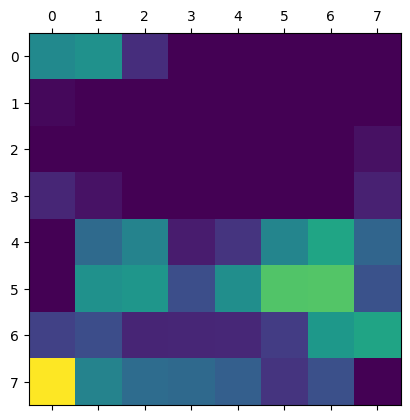

In [65]:
heatmap = np.sum(last_conv_layer_output, axis=-1)
heatmap = tf.nn.relu(heatmap)
plt.matshow(heatmap)

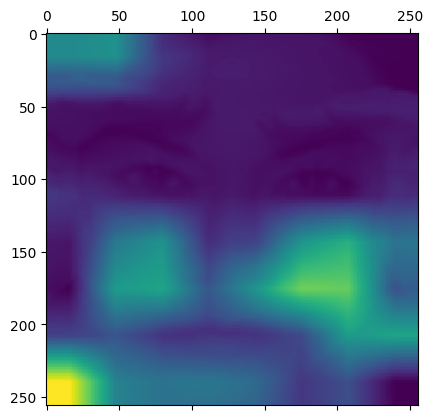

In [66]:
resized_heatmap = cv2.resize(np.array(heatmap), (256, 256))
plt.matshow(resized_heatmap*2555+img_array[0, :, :, 0]/255)